In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
import lightgbm as lgb

In [3]:
### Map@K

def precision_at_k(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    return len(set(predicted) & set(actual)) / float(k)

def mapk(actual_list, predicted_list, k):
    return np.mean([precision_at_k(a, p, k) for a, p in zip(actual_list, predicted_list)])

def calculate_mapk(val_df, k):
    users = val_df['user_ip'].unique()
    actual = []
    predicted = []

    for user in users:
        user_data = val_df[val_df['user_ip'] == user]
        actual_ratings = user_data[user_data['rating'] == 1]['product_id'].tolist()
        predicted_ratings = user_data.sort_values(by='predicted_rating', ascending=False)['product_id'].tolist()

        actual.append(actual_ratings)
        predicted.append(predicted_ratings)

    return mapk(actual, predicted, k)

# # Пример использования
# for k in [1,3,5]:
#   mapk_score = calculate_mapk(val_df_for_cf_train, k)
#   print(f'MAP@{k}:', mapk_score)

In [4]:
df_exp_ratings = pd.read_csv('Data/explicit_ratings_en.csv') # Явные оценки пользователей (1-10), % просмотра
df_imp_ratings = pd.read_csv('Data/implicit_ratings_en.csv') # Не явные оценки, время просмотра страницы с видосиком
df_users = pd.read_csv('Data/users_en.csv') # Информация о пользователе
df_items = pd.read_csv('Data/items_en.csv') # Информация о курсах

In [5]:
df_exp_ratings.head()

,user_id,item_id,watch_percentage,created_at,rating
0,224557,510,100,2018-09-28 16:18:29,10
1,224557,615,100,2018-09-28 16:22:22,10
2,224557,7680,100,2018-09-28 16:23:34,10
3,224293,510,100,2018-09-28 17:20:30,10
4,224293,515,100,2018-09-28 17:40:02,10


In [6]:
len(df_exp_ratings)

3659

`item_id` - Идентификтор курса <br/>
`user_id` - Идентификатор пользователя <br/>
`watch_percentage` - Процент прохождения курса пользователем <br/>
`created_at` - дата и время (видимо, занесения данных в базу, т.е. оценки курса)<br/>
`rating` - Оценка курса пользователем по шкале от 1 до 10

In [7]:
df_imp_ratings.head()

,item_id,user_id,created_at
0,510,4287,2016-11-02 20:59:23
1,510,4287,2017-06-20 00:33:46
2,511,4287,2017-06-20 00:44:42
3,512,4287,2017-06-20 00:52:11
4,513,4287,2017-06-20 00:54:41


In [8]:
df_users.head(5)

,user_id,job
0,384,NaN
1,421,NaN
2,530,NaN
3,672,NaN
4,752,NaN


`user_id` - Идентификатор пользователя <br/>
`job` - Работа, указанная пользователем

In [9]:
df_items.head(5)

,item_id,language,name,nb_views,description,created_at,Difficulty,Job,Software,Theme,duration,type
0,510,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,Beginner,[],['OneDrive'],['Discover'],42.0,tutorial
1,511,en,"Add, restore, delete documents on OneDrive",547.0,"To create a new document in OneDriveclick New,...",2016,Beginner,[],['OneDrive'],"['Share', 'Produce', 'Organize']",122.0,tutorial
2,512,en,Share documents,607.0,"By default, all content is private, so you don...",2016,Beginner,[],['OneDrive'],"['Share', 'Collaborate']",176.0,tutorial
3,513,en,Recycle bin,278.0,"When you delete a file or afolder, OneDrive gi...",2016,Beginner,"['Accounting', 'Financial', 'Human resources',...",['OneDrive'],"['Produce', 'Organize']",46.0,tutorial
4,514,en,Sync OneDrive for Business to your computer (W...,312.0,The one drive synchronization application is a...,2016,Beginner,[],['OneDrive'],"['Produce', 'Organize']",163.0,tutorial


In [10]:
df_items.nunique()

item_id        1167
language          1
name           1130
nb_views        223
description    1009
created_at        6
Difficulty        3
Job              43
Software         62
Theme            63
duration        316
type              3
dtype: int64

`item_id` - Идентификтор курса <br/>
`language` - Язык курса (в данном случае - английский) <br/>
`name` - Название <br/>
`nb_views` - Количество просмотров курса <br/>
`description` - Описание содержания <br/>
`created_at` - Год создания курса <br/>
`Difficulty` - Уровень сложности (`Beginner`, `Intermediate`, `Advanced`, `nan`) <br/>
`Job` - Список сфер деятельности, для которых курс сделан <br/>
`Software` - ПО (видимо, которое нужно для прохождения курса) <br/>
`Theme` - тема курса (не связана с проф. навыками) <br/>
`Duration` - Продолжительность курса в секундах (курс - это почти всегда одно короткое видео, как оказалось) <br/>
`Type` - Тип курса (`Tutorial`, `webcast`, `use_case`)

In [11]:
df_items[df_items['Job'] == '[]']['item_id'].count() / df_items['item_id'].count()

np.float64(0.7446443873179092)

In [12]:
df_items[df_items['Software'] == '[]']['item_id'].count() / df_items['item_id'].count()

np.float64(0.05312767780634105)

In [13]:
df_items[df_items['Theme'] == '[]']['item_id'].count() / df_items['item_id'].count()

np.float64(0.2544987146529563)

**Вывод:** <br>
- *Job* слишком много пропущенных значений - использовать в качестве параметра не получится
- *Software* попробуем
- *Theme* ну нормально так пропусков. Не будем использовать в качестве параметра

# 1. Оценка рейтингов

In [14]:
df_rating_of_cours = pd.merge(df_exp_ratings, df_items, on=['item_id'], how='inner')
df_rating_of_cours['Software'] = df_rating_of_cours['Software'].apply(lambda x: x[1:-1].split(','))
df_rating_of_cours['Max'] = df_rating_of_cours['Software'].apply(lambda x: len(x))
df_rating_of_cours[df_rating_of_cours['Max'] > 2].head()

,user_id,item_id,watch_percentage,created_at_x,rating,language,name,nb_views,description,created_at_y,Difficulty,Job,Software,Theme,duration,type,Max
53,277945,4422,33,2019-08-21 21:59:00,4,en,Creating a group,92.0,Creating a group and I would Welcome to this t...,2017,Beginner,"['Human resources', 'Assistant']","['Outlook Online', 'Outlook', 'Groups']","['Collaborate', 'Communicate']",158.0,tutorial,3
107,277945,126663,100,2019-10-21 13:55:32,10,en,Microsoft Search,111.0,NaN,2019,NaN,[],"['Word', 'Excel', 'PowerPoint']",['New features'],34.0,tutorial,3
345,322302,4423,100,2019-05-07 20:43:38,10,en,Having a conversation within a group,83.0,Having a conversation within a group hello and...,2017,Beginner,"['Human resources', 'Assistant']","['Outlook Online', 'Outlook', 'Groups']","['Collaborate', 'Communicate']",201.0,tutorial,3
857,537825,126663,100,2020-07-18 19:30:16,10,en,Microsoft Search,111.0,NaN,2019,NaN,[],"['Word', 'Excel', 'PowerPoint']",['New features'],34.0,tutorial,3
898,545083,1935,100,2020-08-27 12:24:32,10,en,Organise meetings for new projects,323.0,"As part of your mandate as project manager,you...",2017,Beginner,"['Project manager', 'Project management']","['Skype for Business', 'Outlook', 'Project O...",['Organize'],168.0,use_case,3


In [15]:
df_items

,item_id,language,name,nb_views,description,created_at,Difficulty,Job,Software,Theme,duration,type
0,510,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,Beginner,[],['OneDrive'],['Discover'],42.0,tutorial
1,511,en,"Add, restore, delete documents on OneDrive",547.0,"To create a new document in OneDriveclick New,...",2016,Beginner,[],['OneDrive'],"['Share', 'Produce', 'Organize']",122.0,tutorial
2,512,en,Share documents,607.0,"By default, all content is private, so you don...",2016,Beginner,[],['OneDrive'],"['Share', 'Collaborate']",176.0,tutorial
3,513,en,Recycle bin,278.0,"When you delete a file or afolder, OneDrive gi...",2016,Beginner,"['Accounting', 'Financial', 'Human resources',...",['OneDrive'],"['Produce', 'Organize']",46.0,tutorial
4,514,en,Sync OneDrive for Business to your computer (W...,312.0,The one drive synchronization application is a...,2016,Beginner,[],['OneDrive'],"['Produce', 'Organize']",163.0,tutorial
...,...,...,...,...,...,...,...,...,...,...,...,...
1162,422593,en,Create custom fields,22.0,NaN,2021,NaN,[],['Bookings'],"['Produce', 'Customize']",81.0,tutorial
1163,422594,en,Make a reservation [Customer],22.0,NaN,2021,NaN,[],['Bookings'],['Produce'],133.0,tutorial
1164,422595,en,Make a reservation [Staff],19.0,NaN,2021,NaN,[],['Bookings'],['Produce'],115.0,tutorial
1165,422596,en,Manage your availabilities,19.0,NaN,2021,NaN,[],['Bookings'],['Organize'],102.0,tutorial


# 2.  ДАММИ-ПЕРЕМЕННЫЕ

In [34]:
# Применяем MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
import ast

df_merged = pd.merge(df_exp_ratings, df_items, on=['item_id'], how='left')
# Безопасно преобразуем строки в списки
df_merged['Software'] = df_merged['Software'].apply(ast.literal_eval)
df_merged['Theme'] = df_merged['Theme'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()
split_tags = pd.DataFrame(mlb.fit_transform(df_merged["Software"]),
                         columns=mlb.classes_)

df_half_dum = pd.merge(df_merged, split_tags, left_index=True, right_index=True)
df_half_dum = df_half_dum.drop(['Software'], axis=1)
df_half_dum.head()

,user_id,item_id,watch_percentage,created_at_x,rating,language,name,nb_views,description,created_at_y,...,SharePoint (Modern Sites),Skype VS Teams,Skype Voice & Devices,Skype for Business,Stream,Sway,To Do,Windows 10,Word,Yammer
0,224557,510,100,2018-09-28 16:18:29,10,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,...,0,0,0,0,0,0,0,0,0,0
1,224557,615,100,2018-09-28 16:22:22,10,en,Tell me what you want to do,184.0,Tell me brings featuresand helps topic to your...,2016,...,0,0,0,0,0,0,0,0,0,0
2,224557,7680,100,2018-09-28 16:23:34,10,en,Create a meeting in the group calendar,73.0,The Groups calendar helps youto track all the ...,2017,...,0,0,0,0,0,0,0,0,0,0
3,224293,510,100,2018-09-28 17:20:30,10,en,What is OneDrive for Business?,1114.0,OneDrive for Businessis an online libraryto st...,2016,...,0,0,0,0,0,0,0,0,0,0
4,224293,515,100,2018-09-28 17:40:02,10,en,Work with documents in a synced library folder...,253.0,Once you sync your one drive library to your c...,2016,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_half_dum[df_half_dum.columns[16:]].sum().sort_values(ascending=False)

Microsoft Teams               680
Excel                         625
Outlook                       355
OneDrive                      345
SharePoint (Modern Sites)     238
Power BI                      207
PowerPoint                    152
Yammer                        108
Skype for Business             99
Sway                           92
Word                           80
Office 365 portal              70
Forms                          63
Windows 10                     54
To Do                          53
Outlook Online                 51
Kaizala                        47
Planner                        43
SharePoint (Classic Sites)     35
Stream                         32
Project Online                 31
OneNote                        29
Microsoft Lists                21
Skype Voice & Devices          16
Salestim                       14
Groups                         13
Flow                           13
Office Online                  11
PowerApps                      10
Skype VS Teams

In [36]:
# Объединим все ПО, которые встречаются в курсах менее 50 раз в одну категорию

# PO_counts = df_half_dum[df_half_dum.columns[16:]].sum().sort_values(ascending=False)
# indices = PO_counts[PO_counts < 50].index.tolist()
# df_half_dum['other_software'] = df_half_dum[indices].any(axis=1).astype(int)
# df_half_dum = df_half_dum.drop(indices, axis=1)
# df_half_dum.head()

In [37]:
df_half_dum.columns

Index(['user_id', 'item_id', 'watch_percentage', 'created_at_x', 'rating',
       'language', 'name', 'nb_views', 'description', 'created_at_y',
       'Difficulty', 'Job', 'Theme', 'duration', 'type', 'Bookings', 'Delve',
       'Excel', 'FindTime', 'Flow', 'Forms', 'Groups', 'Kaizala', 'LetSignit',
       'Microsoft Edge Chromium', 'Microsoft Lists', 'Microsoft Teams',
       'Office 365 portal', 'Office Online', 'OneDrive', 'OneNote', 'Outlook',
       'Outlook Online', 'Planner', 'Power BI', 'PowerApps', 'PowerPoint',
       'Project Online', 'Salestim', 'SharePoint (Classic Sites)',
       'SharePoint (Modern Sites)', 'Skype VS Teams', 'Skype Voice & Devices',
       'Skype for Business', 'Stream', 'Sway', 'To Do', 'Windows 10', 'Word',
       'Yammer'],
      dtype='object')

Будем использовать для обучения моделей для предсказания rating такие признаки, как: nb_views, created_at_y, duration, software

In [38]:
columns_for_models = ['rating', 'nb_views', 'created_at_y', 'duration', 'Bookings', 'Delve',
       'Excel', 'FindTime', 'Flow', 'Forms', 'Groups', 'Kaizala', 'LetSignit',
       'Microsoft Edge Chromium', 'Microsoft Lists', 'Microsoft Teams',
       'Office 365 portal', 'Office Online', 'OneDrive', 'OneNote', 'Outlook',
       'Outlook Online', 'Planner', 'Power BI', 'PowerApps', 'PowerPoint',
       'Project Online', 'Salestim', 'SharePoint (Classic Sites)',
       'SharePoint (Modern Sites)', 'Skype VS Teams', 'Skype Voice & Devices',
       'Skype for Business', 'Stream', 'Sway', 'To Do', 'Windows 10', 'Word',
       'Yammer']

# for column in indices:
#        columns_for_models.remove(column)

numeric = ['rating', 'nb_views', 'created_at_y', 'duration']
numeric_factors = [ 'nb_views', 'created_at_y', 'duration']
df_for_models = df_half_dum[columns_for_models]
df_for_models.head()

,rating,nb_views,created_at_y,duration,Bookings,Delve,Excel,FindTime,Flow,Forms,...,SharePoint (Modern Sites),Skype VS Teams,Skype Voice & Devices,Skype for Business,Stream,Sway,To Do,Windows 10,Word,Yammer
0,10,1114.0,2016,42.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,184.0,2016,57.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,73.0,2017,72.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,1114.0,2016,42.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,253.0,2016,87.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


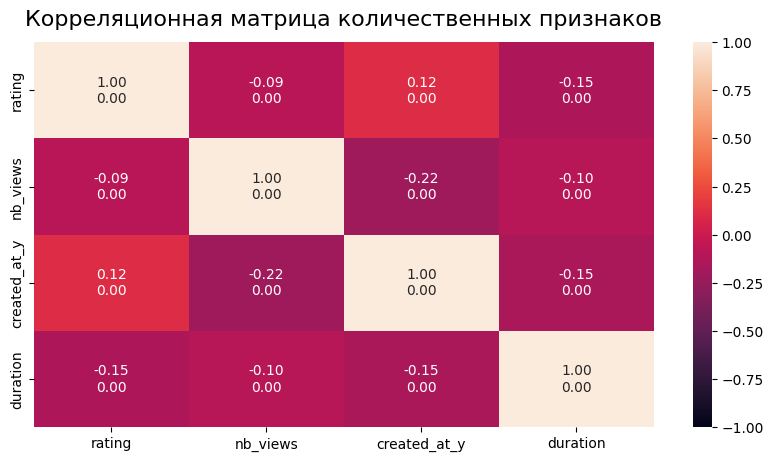

In [39]:
def get_spearman(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

correlation = df_for_models[numeric].corr(method = 'spearman')
text = [[get_spearman(df_for_models[i], df_for_models[j]) for i in numeric] for j in numeric]
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot = text, fmt='' )
heatmap.set_title('Корреляционная матрица количественных признаков', fontdict={'fontsize':16}, pad=12);

Подготовим целевую переменную для бинарной классификации: 1, если рейтинг >= 7, 0, если рейтинг <7

In [40]:
df_for_models.rating = df_for_models.rating.apply(lambda x: 1 if x >=7 else -1)
df_for_models.head()

C:\Users\socol\AppData\Local\Temp\ipykernel_11616\246437313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_models.rating = df_for_models.rating.apply(lambda x: 1 if x >=7 else -1)


,rating,nb_views,created_at_y,duration,Bookings,Delve,Excel,FindTime,Flow,Forms,...,SharePoint (Modern Sites),Skype VS Teams,Skype Voice & Devices,Skype for Business,Stream,Sway,To Do,Windows 10,Word,Yammer
0,1,1114.0,2016,42.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,184.0,2016,57.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,73.0,2017,72.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1114.0,2016,42.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,253.0,2016,87.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Нормализация

In [41]:
# Определение признаков и целевой переменной
X = df_for_models.drop(columns=['rating'])
y = df_for_models['rating']

# Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_numeric = X_train[numeric_factors]
X_test_numeric = X_test[numeric_factors]


# Инициализация и обучение scaler на тренировочных данных
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train_numeric.select_dtypes(include=['int64', 'float64']))

# Преобразование в DataFrame (опционально)
X_train_scaled_numeric = pd.DataFrame(X_train_scaled_numeric, columns=numeric_factors, index=X_train_numeric.index)

# Добавим dummy столбцы
X_train_final = pd.concat([X_train_scaled_numeric, X_train.drop(numeric_factors, axis=1)], axis=1)

X_test_scaled_numeric = scaler.transform(X_test[numeric_factors])
X_test_scaled_numeric = pd.DataFrame(
    X_test_scaled_numeric, 
    columns=numeric_factors,
    index=X_test_numeric.index
)

# Объединение с one-hot
X_test_final = pd.concat([X_test_scaled_numeric, X_test.drop(numeric_factors, axis=1)], axis=1)


# Логистическая регрессия

In [44]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_final, y_train)

# Оценка моделей
log_reg_score = log_reg_model.score(X_test_final, y_test)

y_pred = log_reg_model.predict(X_test_final)
y_pred_proba = [proba[1] for proba in log_reg_model.predict_proba(X_test_final)]

roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
print(f'Logistic Regression f1:: {f1}')

print(f'Logistic Regression accuracy: {log_reg_score}')
print(f'Logistic Regression roc_auc:: {roc_auc}')

Logistic Regression f1:: 0.8979591836734694
Logistic Regression accuracy: 0.8155737704918032
Logistic Regression roc_auc:: 0.6820896464646465


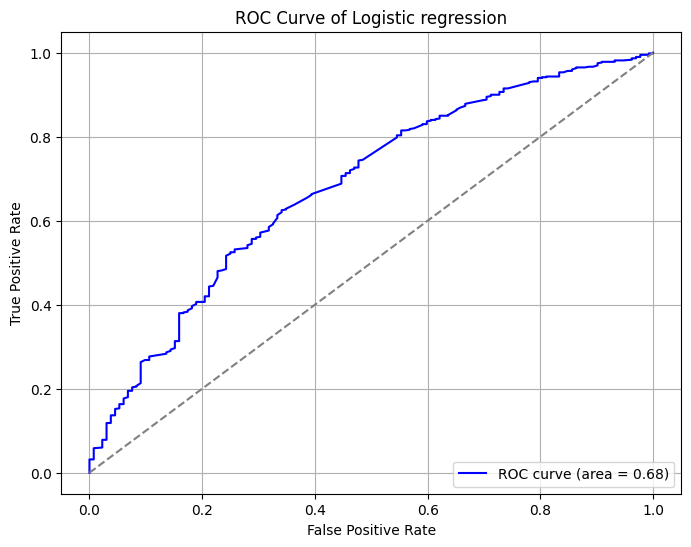

In [43]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba)
auc_log = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'ROC curve (area = {auc_log:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [45]:
val_df_for_content = pd.DataFrame(y_test.copy())
val_df_for_content['predicted_rating'] = y_pred_proba
val_df_for_content['user_ip'] = df_half_dum.loc[y_test.index].user_id
val_df_for_content['product_id'] = df_half_dum.loc[y_test.index].item_id
MAPK_log = []

for k in [1,3,5]:
  mapk_score = calculate_mapk(val_df_for_content, k)
  print(f'MAP@{k}:', round(mapk_score, 3))
  MAPK_log.append(mapk_score)

MAP@1: 0.775
MAP@3: 0.421
MAP@5: 0.291


# Gradient Boosting Desicion Trees

## LightGBM

In [46]:
# Создание пула данных для LightGBM
train_data = lgb.Dataset(X_train_final, label=y_train)
test_data = lgb.Dataset(X_test_final, label=y_test, reference=train_data)

# Параметры модели
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Обучение модели
gbm = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, test_data])

# Прогнозирование
y_pred_proba_lightgbm = gbm.predict(X_test_final, num_iteration=gbm.best_iteration)

# Преобразование вероятностей в метки
y_pred_binary = np.where(y_pred_proba_lightgbm > 0.5, 1, -1)

# Оценка точности
accuracy_lightgbm = accuracy_score(y_test, y_pred_binary)
roc_auc_lightgbm = roc_auc_score(y_test, y_pred_proba_lightgbm)
f1_lightgbm = f1_score(y_test, y_pred_binary)
precision_lightgbm = precision_score(y_test, y_pred_binary)
recall_lightgbm = recall_score(y_test, y_pred_binary)

print(f"Точность: {accuracy_lightgbm:.4f}")
print(f'Precision: {precision_lightgbm}')
print(f'Recall: {recall_lightgbm}')
print(f"F1-метрика: {f1_lightgbm:.4f}")
print(f'roc_auc: {roc_auc_lightgbm:.4f}')

Точность: 0.8292
Precision: 0.8359264497878359
Recall: 0.985
F1-метрика: 0.9044
roc_auc: 0.6772


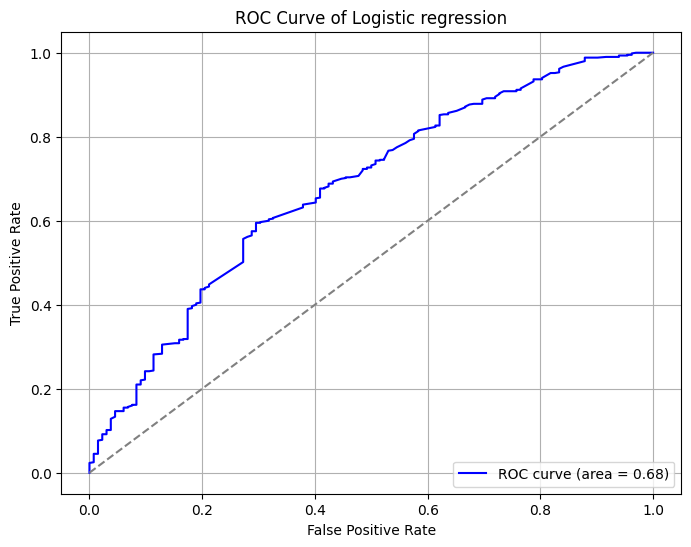

In [48]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_lightgbm)
auc_log = roc_auc_score(y_test, y_pred_proba_lightgbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'ROC curve (area = {auc_log:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [47]:
val_df_for_content = pd.DataFrame(y_test.copy())
val_df_for_content['predicted_rating'] = y_pred_proba_lightgbm
val_df_for_content['user_ip'] = df_half_dum.loc[y_test.index].user_id
val_df_for_content['product_id'] = df_half_dum.loc[y_test.index].item_id
MAPK_log = []

for k in [1,3,5]:
  mapk_score = calculate_mapk(val_df_for_content, k)
  print(f'MAP@{k}:', round(mapk_score, 3))
  MAPK_log.append(mapk_score)

MAP@1: 0.794
MAP@3: 0.422
MAP@5: 0.292


# Просмотр данных

Text(0.5, 1.0, 'Удельный вес оценок')

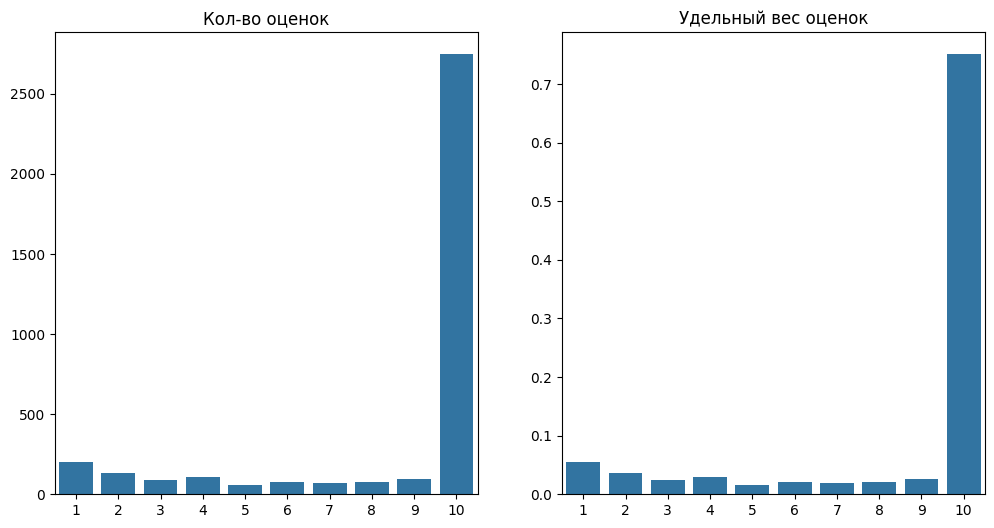

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.barplot(x=df_rating_of_cours['rating'].value_counts().index.to_list(), y=df_rating_of_cours['rating'].value_counts().values, ax=axes[0])
sns.barplot(x=df_rating_of_cours['rating'].value_counts(normalize=True).index.to_list(), y=df_rating_of_cours['rating'].value_counts(normalize=True).values, ax=axes[1])

axes[0].set_title('Кол-во оценок')
axes[1].set_title('Удельный вес оценок')

**Вывод:** 

In [50]:
df_exp_ratings['user_id'].value_counts()

user_id
604039    134
537825    127
277945    101
295494     67
605299     64
         ... 
295180      1
187166      1
236781      1
546675      1
544309      1
Name: count, Length: 822, dtype: int64

**Кол-во пользователей, у которых больше или равно 4 оценок**

In [51]:
len(df_exp_ratings['user_id'].value_counts()[df_exp_ratings['user_id'].value_counts() >= 4]) / len(df_exp_ratings['user_id'].value_counts())


0.2542579075425791

In [52]:
df_rating_of_cours['type'].value_counts(normalize=True)

type
tutorial    0.935502
use_case    0.042361
webcast     0.022137
Name: proportion, dtype: float64